In [35]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from pathlib import Path
import tensorflow_addons as tfa
import os
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf

In [36]:
train_path = "/kaggle/input/surface-crack/train/"
valid_path = "/kaggle/input/surface-crack/valid/"
test_path = "/kaggle/input/surface-crack/test/"

img_size = 248
batch_size = 24

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rotation_range=30,
        brightness_range=[0.2,2.0],
        horizontal_flip=True,
    width_shift_range=0.2, height_shift_range=0.2
)

test_datagen = ImageDataGenerator(
)

In [37]:
train_generator =  train_datagen.flow_from_directory(
    directory=train_path,
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)

valid_generator = train_datagen.flow_from_directory(
    directory=valid_path,
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=batch_size,
    class_mode="categorical",
    subset='training',
    shuffle=True,
    seed=42
)
    
test_generator = train_datagen.flow_from_directory(
    directory=test_path,
    target_size=(img_size, img_size),
    color_mode="rgb",
    batch_size=1,
    class_mode="categorical",
    subset='training',
    shuffle=False,
    seed=42
)


Found 600 images belonging to 2 classes.
Found 200 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [38]:
base_model =tf.keras.applications.resnet50.ResNet50(weights="imagenet", include_top=False, input_shape=(img_size,img_size,3))
base_model.trainable = False 
base_model.training=False

In [39]:
from tensorflow.keras import layers, models

flatten_layer = layers.GlobalAveragePooling2D()
dense_layer_0 = layers.Dense(256, activation='relu')
dense_layer_1 = layers.Dense(128, activation='relu')
prediction_layer = layers.Dense(2, activation='softmax')


model = models.Sequential([
    base_model,
    flatten_layer,
#     dense_layer_0,
#     dense_layer_1,
    prediction_layer
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_4 ( (None, 2048)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 2)                 4098      
Total params: 23,591,810
Trainable params: 4,098
Non-trainable params: 23,587,712
_________________________________________________________________


In [40]:
from tensorflow.keras.callbacks import EarlyStopping


model.compile(
    optimizer=tf.keras.optimizers.Adam(0.1),
    
    loss= [
        tf.keras.losses.CategoricalCrossentropy()
    ],
    
    metrics=[
        tf.keras.metrics.Precision(name='precision_met'),
             tf.keras.metrics.Recall(name='recall_met'),
             tfa.metrics.F1Score(num_classes=2)
            ],
)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = f"/kaggle/working/surface_crack.h5",
                                                  monitor = 'val_precision_met',
                                                  verbose = 1, 
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                 mode='max',)
es = EarlyStopping(monitor='val_precision_met', mode='max', patience=5,  
                   restore_best_weights=True)


In [41]:
hist = model.fit(train_generator, 
          validation_data=test_generator,
          epochs=50,
          batch_size=batch_size, 
          callbacks=[
                    es,
                     checkpointer
                    ]
         )

Epoch 1/50
25/25 [==============================] - 20s 633ms/step - loss: 11.5763 - precision_met: 0.7133 - recall_met: 0.7133 - f1_score: 0.7132 - val_loss: 4.3078 - val_precision_met: 0.8200 - val_recall_met: 0.8200 - val_f1_score: 0.8140

Epoch 00001: val_precision_met improved from -inf to 0.82000, saving model to /kaggle/working/surface_crack.h5
Epoch 2/50
25/25 [==============================] - 15s 601ms/step - loss: 2.4827 - precision_met: 0.8817 - recall_met: 0.8817 - f1_score: 0.8817 - val_loss: 5.5357 - val_precision_met: 0.8050 - val_recall_met: 0.8050 - val_f1_score: 0.7973

Epoch 00002: val_precision_met did not improve from 0.82000
Epoch 3/50
25/25 [==============================] - 15s 624ms/step - loss: 2.0448 - precision_met: 0.8983 - recall_met: 0.8983 - f1_score: 0.8983 - val_loss: 2.0055 - val_precision_met: 0.9100 - val_recall_met: 0.9100 - val_f1_score: 0.9093

Epoch 00003: val_precision_met improved from 0.82000 to 0.91000, saving model to /kaggle/working/surfa

In [42]:
# test data
results = model.evaluate(test_generator, verbose=0)
print(f'''
Precision for test data :{results[1]}
Recall for test data :{results[2]}
F1 SCORE for test data :{(results[3][0]+results[3][1])/2}
''')


Precision for test data :0.9950000047683716
Recall for test data :0.9950000047683716
F1 SCORE for test data :0.994999885559082



In [50]:
# Valid data
results = model.evaluate(valid_generator, verbose=0)
print(f'''
Precision for valid data :{results[1]}
Recall for valid data :{results[2]}
F1 SCORE for valid data :{(results[3][0]+results[3][1])/2}
''')


Precision for valid data :0.9449999928474426
Recall for valid data :0.9449999928474426
F1 SCORE for valid data :0.9448331594467163



In [69]:
y_pred = np.squeeze((model.predict(test_generator) >= 0.5).astype(np.int))
y_pred=np.argmax(y_pred,axis=-1)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


In [70]:
test_generator.class_indices

{'Negative': 0, 'Positive': 1}

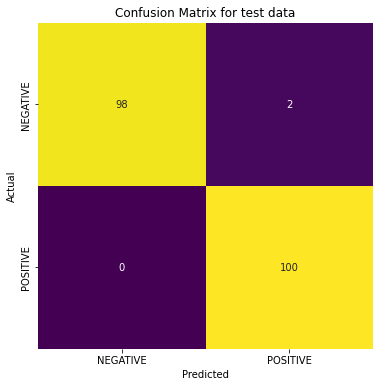

In [94]:
cm = confusion_matrix(test_generator.labels, y_pred)
clr = classification_report(test_generator.labels, y_pred, target_names=["NEGATIVE", "POSITIVE"])
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='viridis', cbar=False)
plt.xticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.yticks(ticks=np.arange(2) + 0.5, labels=["NEGATIVE", "POSITIVE"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for test data")
plt.show()

In [79]:
fig = px.line(
    hist.history,
    y=['precision_met','val_precision_met'],
    labels={'index': "Epoch", 'value': "Precision"},
    title="Precision for training and validation data")
fig.show()


In [95]:
fig = px.line(
    hist.history,
    y=['recall_met','val_recall_met'],
    labels={'index': "Epoch", 'value': "Recall"},
    title="Recall for training and validation data")
fig.show()


In [88]:
f1_score = [np.average(i) for i in hist.history['f1_score']]
val_f1_score = [np.average(i) for i in hist.history['val_f1_score']]

In [101]:
dict_ = {"F1 SCORE":f1_score, "Val F1 SCORE":val_f1_score}

In [103]:
fig = px.line(
    dict_,
    y=["F1 SCORE", "Val F1 SCORE"],
    labels={'index': "Epoch", 'value': "F1 SCORE"},
    title="F1 SCORE for training and validaion data")
fig.show()